In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
vgg16 = torchvision.models.vgg16(weights=True)
# vgg16.features
# vgg16.classifier

c:\Users\neo64\anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\neo64\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
class FCN(nn.Module):
	def __init__(self, n_class=21):
		super(FCN, self).__init__()
		self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
		self.relu1_1 = nn.ReLU(inplace=True)
		self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
		self.relu1_2 = nn.ReLU(inplace=True)
		self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
		
		self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
		self.relu2_1 = nn.ReLU(inplace=True)
		self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
		self.relu2_2 = nn.ReLU(inplace=True)
		self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

		self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
		self.relu3_1 = nn.ReLU(inplace=True)
		self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
		self.relu3_2 = nn.ReLU(inplace=True)
		self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
		self.relu3_3 = nn.ReLU(inplace=True)
		self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

		self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
		self.relu4_1 = nn.ReLU(inplace=True)
		self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
		self.relu4_2 = nn.ReLU(inplace=True)
		self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
		self.relu4_3 = nn.ReLU(inplace=True)
		self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

		self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
		self.relu5_1 = nn.ReLU(inplace=True)
		self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
		self.relu5_2 = nn.ReLU(inplace=True)
		self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
		self.relu5_3 = nn.ReLU(inplace=True)
		self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

		self.conv6 = nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=1, padding=0)
		self.relu6 = nn.ReLU(inplace=True)
		self.drop6 = nn.Dropout2d()

		self.conv7 = nn.Conv2d(in_channels=4096, out_channels=4096, kernel_size=1, padding=0)
		self.relu7 = nn.ReLU(inplace=True)
		self.drop7 = nn.Dropout2d()

		self.conv8 = nn.Conv2d(in_channels=4096, out_channels=n_class, kernel_size=1, padding=0)


		self.x2_upsample = nn.ConvTranspose2d(in_channels=n_class, out_channels=n_class, kernel_size=4, stride=2)
		self.x8_upsample = nn.ConvTranspose2d(in_channels=n_class, out_channels=n_class, kernel_size=16, stride=8)
		#self.x16_upsample = nn.ConvTranspose2d(in_channels=n_class, out_channels=n_class, kernel_size=17, stride=16, padding=1, output_padding=1)
		#self.x32_upsample = nn.ConvTranspose2d(in_channels=n_class, out_channels=n_class, kernel_size=33, stride=32, padding=1, output_padding=1)


		self.pool4_pred = nn.Conv2d(in_channels=512, out_channels=n_class, kernel_size=1, padding=0)
		self.pool3_pred = nn.Conv2d(in_channels=256, out_channels=n_class, kernel_size=1, padding=0)

	def forward(self, x):
		x = self.relu1_1(self.conv1_1(x))
		x = self.relu1_2(self.conv1_2(x))
		x = self.maxpool1(x)

		x = self.relu2_1(self.conv2_1(x))
		x = self.relu2_2(self.conv2_2(x))
		x = self.maxpool2(x)

		x = self.relu3_1(self.conv3_1(x))
		x = self.relu3_2(self.conv3_2(x))
		x = self.relu3_3(self.conv3_3(x))
		x = self.maxpool3(x)
		pool3_pred = self.pool3_pred(x)

		x = self.relu4_1(self.conv4_1(x))
		x = self.relu4_2(self.conv4_2(x))
		x = self.relu4_3(self.conv4_3(x))
		x = self.maxpool4(x)
		pool4_pred = self.pool4_pred(x)
		
		x = self.relu5_1(self.conv5_1(x))
		x = self.relu5_2(self.conv5_2(x))
		x = self.relu5_3(self.conv5_3(x))
		x = self.maxpool5(x)


		x = self.drop6(self.relu6(self.conv6(x)))
		x = self.drop7(self.relu7(self.conv7(x)))
		x = self.conv8(x)

		us = self.x2_upsample(x)
		us = us[ :, : , 1:-1, 1:-1]
		#FCN_32s = self.x32_upsample(x)
		
		us_with_pool4_prediction = us + pool4_pred
		#FCN_16s = self.x16_upsample(us_with_pool4_prediction)
		
		us2 = self.x2_upsample(us_with_pool4_prediction)
		us2 = us2[ :, : , 1:-1, 1:-1]
		us2_with_pool3_prediction = us2 + pool3_pred
		FCN_8s = self.x8_upsample(us2_with_pool3_prediction)
		result = FCN_8s[ :, :, 4:-4, 4:-4]

		return result
	
	def copy_params_from_vgg16(self, vgg16):
		features = [
			self.conv1_1, self.relu1_1,
			self.conv1_2, self.relu1_2,
			self.maxpool1,
			self.conv2_1, self.relu2_1,
			self.conv2_2, self.relu2_2,
			self.maxpool2,
			self.conv3_1, self.relu3_1,
			self.conv3_2, self.relu3_2,
			self.conv3_3, self.relu3_3,
			self.maxpool3,
			self.conv4_1, self.relu4_1,
			self.conv4_2, self.relu4_2,
			self.conv4_3, self.relu4_3,
			self.maxpool4,
			self.conv5_1, self.relu5_1,
			self.conv5_2, self.relu5_2,
			self.conv5_3, self.relu5_3,
			self.maxpool5,
		]
		for l1, l2 in zip(vgg16.features, features):
			print(l1)
			if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
				assert l1.weight.size() == l2.weight.size()
				assert l1.bias.size() == l2.bias.size()
				l2.weight.data.copy_(l1.weight.data)
				l2.bias.data.copy_(l1.bias.data)
		
		for layer in features:
			for param in layer.parameters():
				param.requires_grad = False
		
		

In [4]:
class Compose(object):
	def __init__(self, transform_data, transform_target):
		self.transform_data = transform_data
		self.transform_target = transform_target

	def __call__(self, image, target):
		for t in self.transform_data:
			image = t(image)

		for t in self.transform_target:
			target = t(target)
			
		return image, target
	
class Remove255(object):
	def __call__(self, tensor):
		return torch.where(tensor>20, torch.tensor(0), tensor)

transform_target = []
transform_target.append(transforms.Resize((224,224)))
transform_target.append(transforms.PILToTensor())
transform_target.append(Remove255())
transform_data = []
transform_data.append(transforms.Resize((224,224)))
transform_data.append(transforms.ToTensor())
transform_data.append(transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)))
# transform_data.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
transform = Compose(transform_data, transform_target)

In [5]:
VOC2012_train = torchvision.datasets.VOCSegmentation('VOC2012_seg', image_set="train", transforms=transform)
VOC2012_test = torchvision.datasets.VOCSegmentation('VOC2012_seg', image_set="val", transforms=transform)

In [6]:
batch_size = 64
trainloader = DataLoader(VOC2012_train, batch_size=batch_size, shuffle=True)
testloader = DataLoader(VOC2012_train, batch_size=batch_size, shuffle=True)

In [7]:
print(VOC2012_train[0])

(tensor([[[ 0.1254,  0.1597,  0.1597,  ...,  1.0159,  0.9988,  0.9988],
         [ 0.1426,  0.1768,  0.1768,  ...,  1.0331,  1.0159,  1.0159],
         [ 0.1768,  0.1768,  0.1939,  ...,  1.0502,  1.0331,  1.0159],
         ...,
         [-1.9809, -1.9467, -1.9124,  ..., -1.9467, -1.9295, -1.9124],
         [-1.9980, -1.9467, -1.9295,  ..., -1.8439, -1.8610, -1.8268],
         [-2.0152, -1.9638, -1.9295,  ..., -1.8610, -1.8610, -1.8439]],

        [[ 1.3431,  1.3782,  1.3957,  ...,  2.0434,  2.0259,  2.0259],
         [ 1.3606,  1.3957,  1.4132,  ...,  2.0609,  2.0434,  2.0434],
         [ 1.3957,  1.3957,  1.4307,  ...,  2.0784,  2.0609,  2.0434],
         ...,
         [-1.7731, -1.7731, -1.7556,  ..., -1.5280, -1.5280, -1.5105],
         [-1.7556, -1.7731, -1.7556,  ..., -1.4230, -1.4405, -1.4230],
         [-1.7556, -1.7731, -1.7556,  ..., -1.4230, -1.4580, -1.4580]],

        [[ 1.8208,  1.8557,  1.8731,  ...,  2.3786,  2.3960,  2.3960],
         [ 1.8383,  1.8731,  1.8905,  ...,  

In [8]:
model = FCN()
model.to('cuda')
model.copy_params_from_vgg16(vgg16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True

In [9]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [10]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [11]:
lr = (10**-3)*5
momentum = 0.9
weight_decay = 5**-4
optim = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

In [594]:
epoch = 100

loss_fn = nn.CrossEntropyLoss()
save_path = 'fcn/final19.pt'
model.load_state_dict(torch.load(save_path))

for epoch_cnt in range(epoch):

	for index, (data, target) in enumerate(trainloader):
		optim.zero_grad()
		data = data.to('cuda')
		target = target.to('cuda')
		target = torch.squeeze(target)
		target = target.long()
		prediction = model(data)
		# print(prediction.shape, target.shape)
		loss = loss_fn(prediction, target)
		loss.backward()
		optim.step()
	torch.save(model.state_dict(), save_path)
	print(f"finish epoch : {epoch_cnt} (lr = {lr})")
	print(f"loss : {loss}")

finish epoch : 0 (lr = 0.001)
loss : 1.0939750671386719
finish epoch : 1 (lr = 0.001)
loss : 0.9760077595710754
finish epoch : 2 (lr = 0.001)
loss : 1.0911544561386108
finish epoch : 3 (lr = 0.001)
loss : 1.1510682106018066
finish epoch : 4 (lr = 0.001)
loss : 1.046970248222351
finish epoch : 5 (lr = 0.001)
loss : 1.1190918684005737
finish epoch : 6 (lr = 0.001)
loss : 0.836222767829895
finish epoch : 7 (lr = 0.001)
loss : 0.9739610552787781
finish epoch : 8 (lr = 0.001)
loss : 1.01797616481781
finish epoch : 9 (lr = 0.001)
loss : 1.1496601104736328


KeyboardInterrupt: 

C:\Users\neo64\AppData\Local\Temp\ipykernel_45692\2029567585.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', 20)


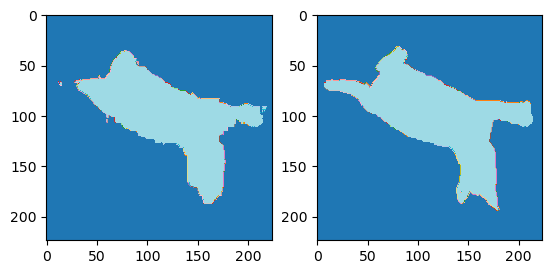

In [19]:
import matplotlib.pyplot as plt
save_path = 'fcn/final21_lr-1234.pt'
model = FCN().to(device)
model.load_state_dict(torch.load(save_path))
with torch.no_grad():
    for index, (input, output) in enumerate(trainloader):
        input = input.to('cuda')
        output = output.to('cuda')
        prediction = model(input)
        prediction = prediction.cpu()
        prediction = prediction[0]
        prediction = torch.argmax(prediction, dim=0)
        '''
        for y in prediction:
            for x in y:
                print(x.item(), end='')
            print()
        print()
        for y in output[0][0]:
            for x in y:
                print(x.item(), end='')
            print()
        break
        '''
        cmap = plt.cm.get_cmap('tab20', 20)
        plt.subplot(121)
        for i in range(20):
            plt.imshow(prediction, cmap=cmap, alpha=0.5)
        plt.subplot(122)
        for i in range(20):
            plt.imshow(output.cpu()[0].squeeze(), cmap=cmap, alpha=0.5)
        break